In [2]:
import hyperopt as hyperopt
import numpy as np
import pandas
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from matplotlib import rcParams
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, robust_scale, quantile_transform

In [1]:
data = pd.read_csv('hotel_bookings.csv')
data.head()

NameError: name 'pd' is not defined

In [160]:
date_list = [col for col in pd.columns if col.__contains__('date')]
time_data = pd.DataFrame(data[date_list])

In [161]:
from datetime import datetime
month_num = lambda x: datetime.strptime(x, '%B').month
time_data.loc[:,'arrival_date_month'] = time_data['arrival_date_month'].map(month_num)
time_data.head()

,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,reservation_status_date
0,2015,7,27,1,1/7/2015
1,2015,7,27,1,1/7/2015
2,2015,7,27,1,2/7/2015
3,2015,7,27,1,2/7/2015
4,2015,7,27,1,3/7/2015


In [164]:
# add in column arrival day for continuous time series by day of year
day_of_year = lambda year, month, day: datetime.strptime(f"{year}-{month}-{day}", "%Y-%m-%d").timetuple().tm_yday
day_list = []
for i in range(len(time_data)):
    yr = time_data.arrival_date_year[i]
    mth = time_data.arrival_date_month[i]
    dy = time_data.arrival_date_day_of_month[i]
    x = day_of_year(yr, mth, dy)
    day_list.append(x)

time_data['year_day'] = pd.DataFrame(day_list, columns=['year_day'])
time_data.head()

,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,reservation_status_date,year_day
0,2015,7,27,1,1/7/2015,182
1,2015,7,27,1,1/7/2015,182
2,2015,7,27,1,2/7/2015,182
3,2015,7,27,1,2/7/2015,182
4,2015,7,27,1,3/7/2015,182


In [170]:
year_format = lambda year, month, day: str(f'{day}/{month}/{year}')
time_data.loc[:,'arrival_date'] = time_data.apply(lambda x: year_format(x['arrival_date_year'], x['arrival_date_month'],
x['arrival_date_day_of_month']), axis=1)
time_data.head()

,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,reservation_status_date,year_day,arrival_date
0,2015,7,27,1,1/7/2015,182,1/7/2015
1,2015,7,27,1,1/7/2015,182,1/7/2015
2,2015,7,27,1,2/7/2015,182,1/7/2015
3,2015,7,27,1,2/7/2015,182,1/7/2015
4,2015,7,27,1,3/7/2015,182,1/7/2015


In [178]:
status_change_time = lambda arrival_date, reservation_date: (datetime.strptime(reservation_date, '%d/%m/%Y') -
                                                            datetime.strptime(arrival_date, '%d/%m/%Y')).days
time_data.loc[:,'change_time'] = time_data.apply(lambda x: status_change_time(x['arrival_date'], x['reservation_status_date']),
                                                 axis=1)
time_data.head()

,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,reservation_status_date,year_day,arrival_date,change_time
0,2015,7,27,1,1/7/2015,182,1/7/2015,0
1,2015,7,27,1,1/7/2015,182,1/7/2015,0
2,2015,7,27,1,2/7/2015,182,1/7/2015,1
3,2015,7,27,1,2/7/2015,182,1/7/2015,1
4,2015,7,27,1,3/7/2015,182,1/7/2015,2


In [182]:
# count number of bookings per day and number of cancellations
time_data['arrival_date'] = pd.to_datetime(time_data['arrival_date'], format='%d/%m/%Y')

In [183]:
time_data.groupby('arrival_date').count()

,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,reservation_status_date,year_day,change_time
arrival_date,,,,,,,
2015-07-01,122,122,122,122,122,122,122
2015-07-02,93,93,93,93,93,93,93
2015-07-03,56,56,56,56,56,56,56
2015-07-04,88,88,88,88,88,88,88
2015-07-05,53,53,53,53,53,53,53
...,...,...,...,...,...,...,...
2017-08-27,174,174,174,174,174,174,174
2017-08-28,211,211,211,211,211,211,211
2017-08-29,125,125,125,125,125,125,125


In [186]:
time_data = pd.concat([time_data, data['is_canceled']], axis = 1)

In [202]:
time_data_by_day = pd.DataFrame(time_data.groupby('arrival_date')['is_canceled'].sum())

In [217]:
time_data_by_day['total_bookings'] = pd.DataFrame(time_data['arrival_date'].value_counts())
time_data_by_day.head()

,is_canceled,total_bookings
arrival_date,,
2015-07-01,19,122
2015-07-02,57,93
2015-07-03,19,56
2015-07-04,43,88
2015-07-05,16,53


<AxesSubplot:xlabel='arrival_date'>

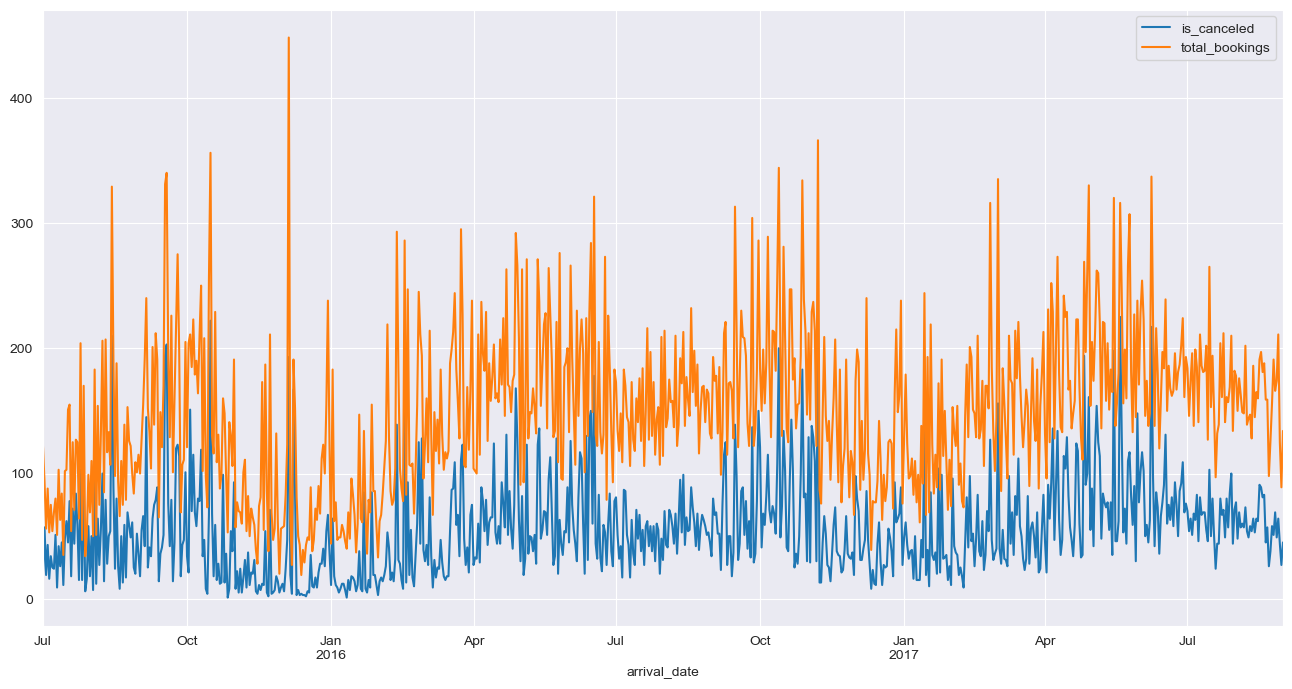

In [220]:
time_data_by_day.plot(figsize = (16, 8))

# Time Series Forecasting using Total Bookings and Separated Time Data

In [295]:
time_train = pd.DataFrame(time_data_by_day.loc[time_data_by_day.index < '01-01-2017']).drop(index='2015-12-05')
time_test = pd.DataFrame(time_data_by_day.loc[time_data_by_day.index >= '01-01-2017'])

In [296]:
def create_feature(df):
    df['day_of_month'] = df.index.day
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['day_of_year'] = df.index.dayofyear
    return df

In [297]:
time_train = create_feature(time_train)

In [298]:
time_train.head()

,is_canceled,total_bookings,prediction_x,prediction_y,prediction,day_of_month,month,year,day_of_year
arrival_date,,,,,,,,,
2015-07-01,19,122,NaN,NaN,NaN,1,7,2015,182
2015-07-02,57,93,NaN,NaN,NaN,2,7,2015,183
2015-07-03,19,56,NaN,NaN,NaN,3,7,2015,184
2015-07-04,43,88,NaN,NaN,NaN,4,7,2015,185
2015-07-05,16,53,NaN,NaN,NaN,5,7,2015,186


In [299]:
time_test = create_feature(time_test)
time_test.head()

,is_canceled,total_bookings,prediction_x,prediction_y,prediction,day_of_month,month,year,day_of_year
arrival_date,,,,,,,,,
2017-01-01,49,128,33.139904,24.214428,24.214428,1,1,2017,1
2017-01-02,61,179,57.508606,34.190792,34.190792,2,1,2017,2
2017-01-03,43,124,29.383745,19.240950,19.240950,3,1,2017,3
2017-01-04,32,96,20.249779,13.850859,13.850859,4,1,2017,4
2017-01-05,38,98,20.012560,13.850859,13.850859,5,1,2017,5


In [300]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error

In [276]:
features = ['total_bookings', 'day_of_month', 'month', 'year',
            'day_of_year']
target = ['is_canceled']

In [301]:
X_train = time_train[features]
y_train = time_train[target]
X_test = time_test[features]
y_test = time_test[target]

In [302]:
reg = xgb.XGBRegressor(n_estimators = 1000, early_stopping_rounds = 50, learning_rate = 0.01)
reg.fit(X_train, y_train, eval_set = [(X_train, y_train), (X_test, y_test)], verbose = True)

[0]	validation_0-rmse:63.86621	validation_1-rmse:72.93114
[1]	validation_0-rmse:63.29563	validation_1-rmse:72.30348
[2]	validation_0-rmse:62.73106	validation_1-rmse:71.68239
[3]	validation_0-rmse:62.17249	validation_1-rmse:71.06765
[4]	validation_0-rmse:61.61994	validation_1-rmse:70.45002
[5]	validation_0-rmse:61.07308	validation_1-rmse:69.84809
[6]	validation_0-rmse:60.53215	validation_1-rmse:69.24328
[7]	validation_0-rmse:59.99707	validation_1-rmse:68.65722
[8]	validation_0-rmse:59.46763	validation_1-rmse:68.06537
[9]	validation_0-rmse:58.94370	validation_1-rmse:67.48924
[10]	validation_0-rmse:58.42519	validation_1-rmse:66.92859
[11]	validation_0-rmse:57.91237	validation_1-rmse:66.36772
[12]	validation_0-rmse:57.40477	validation_1-rmse:65.81887
[13]	validation_0-rmse:56.90275	validation_1-rmse:65.26285
[14]	validation_0-rmse:56.40618	validation_1-rmse:64.70511
[15]	validation_0-rmse:55.91453	validation_1-rmse:64.17361
[16]	validation_0-rmse:55.42849	validation_1-rmse:63.64348
[17]	va

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [303]:
fi = pd.DataFrame(data = reg.feature_importances_, index=reg.feature_names_in_, columns=['importance'])
fi.head()

,importance
total_bookings,0.770025
day_of_month,0.057133
month,0.042136
year,0.068926
day_of_year,0.061780


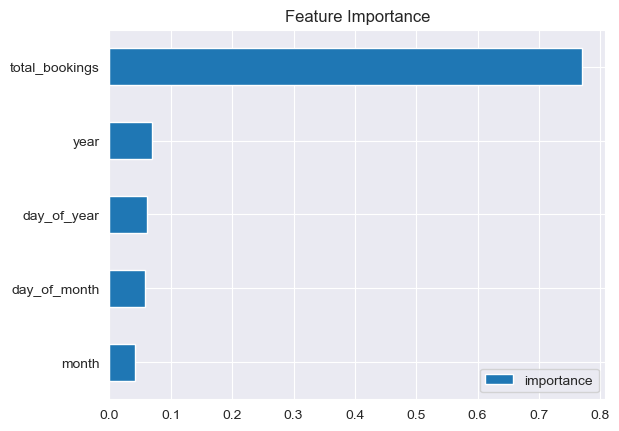

In [304]:
fi.sort_values('importance').plot(kind = 'barh', title = 'Feature Importance')
plt.show()

In [305]:
time_test['prediction'] = reg.predict(X_test)

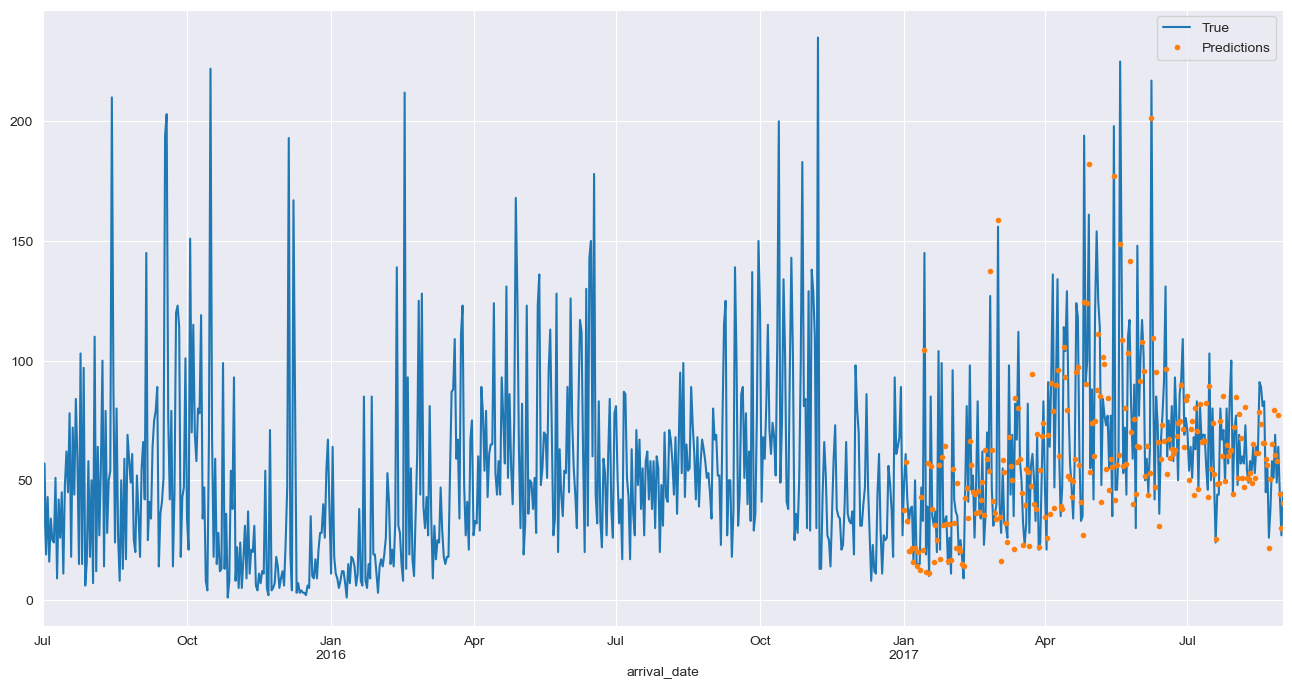

In [307]:
time_data_by_day = time_data_by_day.merge(time_test[['prediction']], how = 'left', left_index=True, right_index=True)
ax = time_data_by_day[['is_canceled']].plot(figsize=(16,8))
time_data_by_day['prediction'].plot(ax = ax, style = '.')
plt.legend(['True', 'Predictions'])
plt.show()

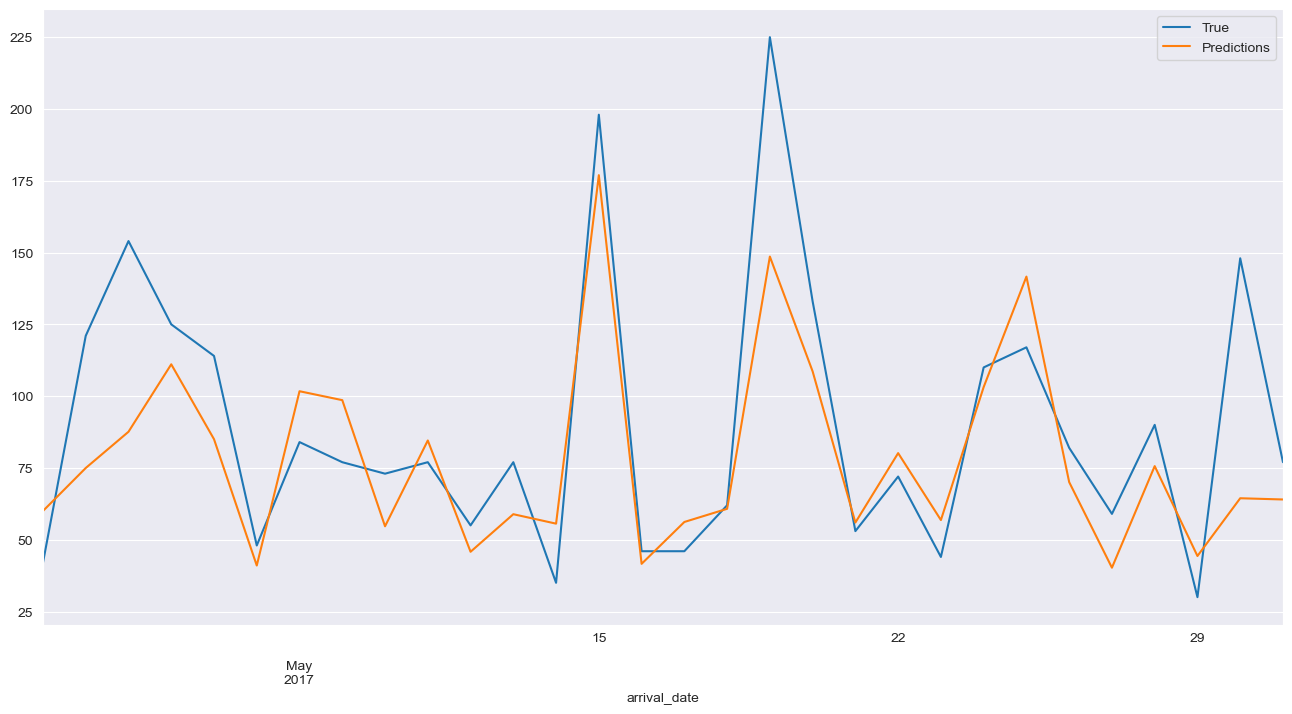

In [308]:
ax = time_data_by_day.loc[(time_data_by_day.index > '05-01-2017') & (time_data_by_day.index < '06-01-2017')]['is_canceled']\
    .plot(figsize=(16,8))
time_data_by_day.loc[(time_data_by_day.index > '05-01-2017') & (time_data_by_day.index < '06-01-2017')]['prediction'] \
    .plot(ax = ax)
plt.legend(['True', 'Predictions'])
plt.show()

In [309]:
np.sqrt(mean_squared_error(y_test['is_canceled'], reg.predict(X_test)))

18.628657494237796

In [286]:
def mape(y_test, pred):
    y_test, pred = np.array(y_test), np.array(pred)
    mape = np.mean(np.abs((y_test - pred) / y_test))
    return mape

In [310]:
mape(y_test['is_canceled'], reg.predict(X_test))

0.20877907365338644

In [346]:
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from hyperopt.pyll import scope
from sklearn.metrics import accuracy_score

In [347]:
space = {'max_depth': scope.int(hp.quniform("max_depth", 1, 5, 1)),
         'gamma': hp.uniform ('gamma', 0,1),
         'reg_alpha' : hp.uniform('reg_alpha', 0,50),
         'reg_lambda' : hp.uniform('reg_lambda', 10,100),
         'colsample_bytree' : hp.uniform('colsample_bytree', 0,1),
         'min_child_weight' : hp.uniform('min_child_weight', 0, 5),
         'n_estimators': 10000,
         'learning_rate': hp.uniform('learning_rate', 0, .15),
         'tree_method':'gpu_hist',
         'gpu_id': 0,
         'random_state': 5,
         'max_bin' : scope.int(hp.quniform('max_bin', 200, 550, 1))}

In [434]:
from sklearn.metrics import log_loss

In [543]:
def hyperparameter_tuning(space):
    model = xgb.XGBRegressor(**space)

    #Define evaluation datasets.
    evaluation = [(X_train, y_train), (X_test, y_test)]
    evaluation_dart = [(X_test, y_test)]

    #Fit the model. Define evaluation sets, early_stopping_rounds, and eval_metric.
    model.fit(X_train, y_train, eval_set = evaluation_dart, verbose = False)
    #Obtain prediction and log_loss score.
    pred = model.predict(X_test)
    loss = mean_squared_error(y_test, pred,squared=False)
    print ("SCORE:", loss)

    #Specify what the loss is for each model.
    return {'loss': loss, 'status': STATUS_OK, 'model': model}

In [355]:
trials = Trials()
best = fmin(fn=hyperparameter_tuning,
            space=space,
            algo=tpe.suggest,
            max_evals=30,
            trials=trials)

print(best)

SCORE:                                                
17.148134287800648                                    
SCORE:                                                                          
16.838887558978893                                                              
SCORE:                                                                          
17.24291585073091                                                               
SCORE:                                                                          
17.014494741443972                                                              
SCORE:                                                                          
17.521994570947015                                                              
SCORE:                                                                          
16.074582616167724                                                              
SCORE:                                                                          

In [356]:
#Create instace of best model.
best_model = trials.results[np.argmin([r['loss'] for r in
                                       trials.results])]['model']

#Examine model hyperparameters
print(best_model)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8119929829715007, early_stopping_rounds=100,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             gamma=0.1580262575196727, gpu_id=0, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.041737253186350215, max_bin=219,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=1, max_leaves=None,
             min_child_weight=0.5863733403943283, missing=nan,
             monotone_constraints=None, n_estimators=10000, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=5, ...)


In [357]:
xgb_preds_best = best_model.predict(X_test)
xgb_score_best = mean_squared_error(y_test, xgb_preds_best, squared=False)
print('RMSE_Best_Model:', xgb_score_best)

RMSE_Best_Model: 16.074582616167724


In [359]:
mape(y_test['is_canceled'], best_model.predict(X_test))

0.18749864075713657

In [362]:
time_test['prediction_2'] = best_model.predict(X_test)

In [363]:
time_data_by_day = time_data_by_day.merge(time_test[['prediction_2']], how = 'left', left_index=True, right_index=True)

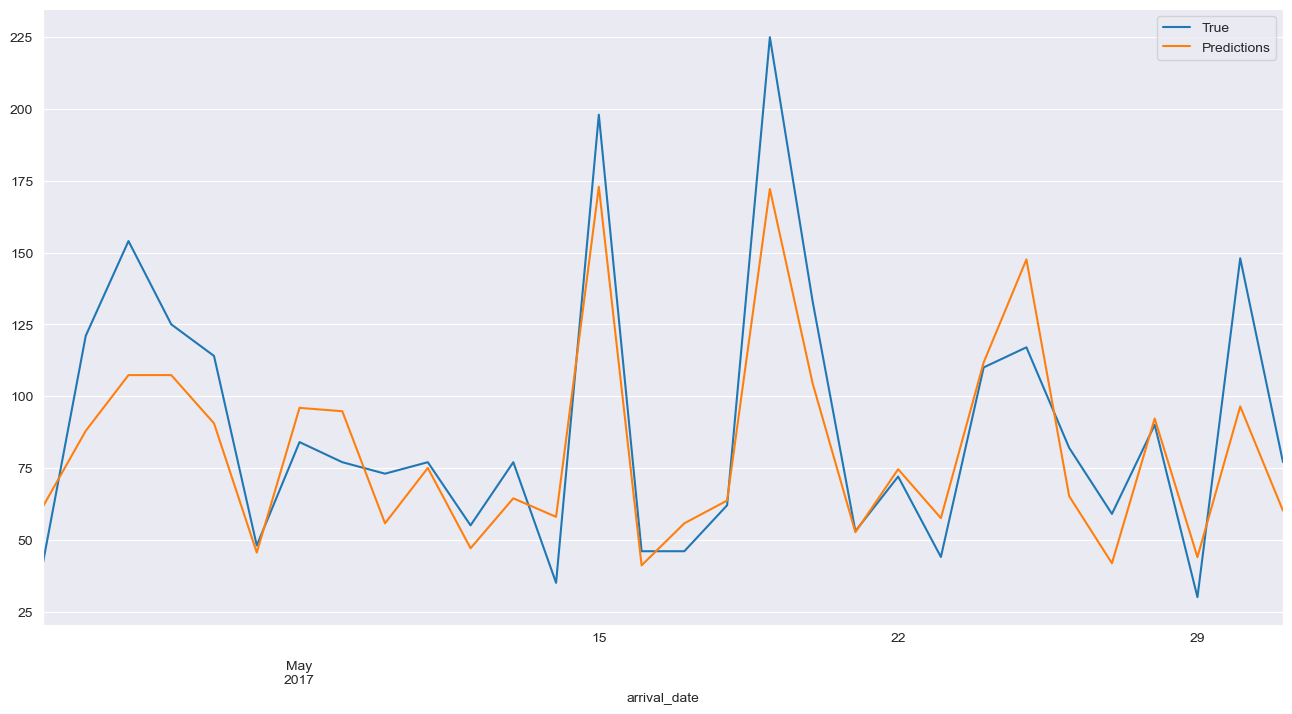

In [364]:
ax = time_data_by_day.loc[(time_data_by_day.index > '05-01-2017') & (time_data_by_day.index < '06-01-2017')]['is_canceled'] \
    .plot(figsize=(16,8))
time_data_by_day.loc[(time_data_by_day.index > '05-01-2017') & (time_data_by_day.index < '06-01-2017')]['prediction_2'] \
    .plot(ax = ax)
plt.legend(['True', 'Predictions'])
plt.show()

In [365]:
time_data_by_day.tail(10)

,is_canceled,total_bookings,prediction_x,prediction_y,prediction_x,prediction_y,prediction,prediction_2
arrival_date,,,,,,,,
2017-08-22,26,98,21.091583,13.150660,13.150660,21.619556,21.619556,31.745173
2017-08-23,38,126,49.681927,31.945234,31.945234,50.519772,50.519772,46.019417
2017-08-24,58,156,63.955566,36.498795,36.498795,65.155518,65.155518,59.816025
2017-08-25,51,191,79.163895,50.533546,50.533546,79.475487,79.475487,81.411400
2017-08-26,69,166,61.273960,38.789463,38.789463,60.715286,60.715286,64.387283
2017-08-27,49,174,58.387615,39.717648,39.717648,58.000015,58.000015,65.791016
2017-08-28,64,211,78.349747,50.882038,50.882038,77.244736,77.244736,85.196548
2017-08-29,44,125,43.176079,27.438889,27.438889,44.311939,44.311939,43.625767
2017-08-30,27,89,31.207724,17.356865,17.356865,30.165794,30.165794,24.175432


In [403]:
def create_lag(df: pd.DataFrame, colx:str = 'is_canceled', n_days:int = 14):
    df['lag1'] = df[f'{colx}'].shift(n_days)
    df['lag2'] = df[f'{colx}'].shift(2*n_days)
    df['lag3'] = df[f'{colx}'].shift(3*n_days)
    df = df.fillna(0)
    return df

In [400]:
time_data_by_day = pd.DataFrame(time_data.groupby('arrival_date')['is_canceled'].sum())
time_data_by_day['total_bookings'] = pd.DataFrame(time_data['arrival_date'].value_counts())
time_data_by_day.head()

,is_canceled,total_bookings
arrival_date,,
2015-07-01,19,122
2015-07-02,57,93
2015-07-03,19,56
2015-07-04,43,88
2015-07-05,16,53


In [404]:
time_data_by_day_2 = create_lag(time_data_by_day)

In [407]:
time_data_by_day_2.tail()

,is_canceled,total_bookings,lag1,lag2,lag3
arrival_date,,,,,
2017-08-27,49,174,53.0,44.0,50.0
2017-08-28,64,211,64.0,71.0,80.0
2017-08-29,44,125,62.0,77.0,50.0
2017-08-30,27,89,91.0,48.0,24.0
2017-08-31,45,134,89.0,69.0,44.0


In [409]:
time_data_by_day_2.index = pd.to_datetime(time_data_by_day_2.index)

In [411]:
time_train_2 = time_data_by_day_2.loc[time_data_by_day_2.index < '2017-08-18']
time_test_2 = time_data_by_day_2.loc[time_data_by_day_2.index >= '2017-08-18']

In [412]:
time_train_2 = create_feature(time_train_2)
time_test_2 = create_feature(time_test_2)

C:\Users\fight\AppData\Local\Temp\ipykernel_58164\3864050251.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['day_of_month'] = df.index.day
C:\Users\fight\AppData\Local\Temp\ipykernel_58164\3864050251.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['month'] = df.index.month
C:\Users\fight\AppData\Local\Temp\ipykernel_58164\3864050251.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the

In [413]:
time_train_2.head()

,is_canceled,total_bookings,lag1,lag2,lag3,day_of_month,month,year,day_of_year
arrival_date,,,,,,,,,
2015-07-01,19,122,0.0,0.0,0.0,1,7,2015,182
2015-07-02,57,93,0.0,0.0,0.0,2,7,2015,183
2015-07-03,19,56,0.0,0.0,0.0,3,7,2015,184
2015-07-04,43,88,0.0,0.0,0.0,4,7,2015,185
2015-07-05,16,53,0.0,0.0,0.0,5,7,2015,186


In [384]:
features.append('lag1')
features.append('lag2')
features.append('lag3')
features

['total_bookings',
 'day_of_month',
 'month',
 'year',
 'day_of_year',
 'lag1',
 'lag1',
 'lag2',
 'lag3']

In [447]:
X_train = time_train_2[features]
X_test = time_test_2[features]
y_train = time_train_2[target]
y_test = time_test_2[target]

In [589]:
space = {'max_depth': scope.int(hp.quniform("max_depth", 1, 15, 1)),
         'max_leaves': scope.int(hp.quniform("max_leaves", 1, 50, 1)),
         'gamma': hp.uniform ('gamma', 0,1),
         'reg_alpha' : hp.uniform('reg_alpha', 0,50),
         'reg_lambda' : hp.uniform('reg_lambda', 10,200),
         'colsample_bytree' : hp.uniform('colsample_bytree', 0,1),
         'min_child_weight' : hp.uniform('min_child_weight', 0, 5),
         'n_estimators': 10000,
         'learning_rate': hp.uniform('learning_rate', 0, .1),
         'tree_method':'gpu_hist',
         'gpu_id': 0,
         'random_state': 7,
         'max_bin' : scope.int(hp.quniform('max_bin', 200, 650, 1)),
         'sampling_method': 'gradient_based',
         'eval_metric': 'rmse',
         'early_stopping_rounds': 100
         }

In [591]:
trials = Trials()
best = fmin(fn=hyperparameter_tuning,
            space=space,
            algo=tpe.suggest,
            max_evals=30,
            trials=trials)

print(best)

SCORE:                                                
12.036468750070156                                    
SCORE:                                                                          
11.354935427976997                                                              
SCORE:                                                                          
13.355553870381529                                                              
SCORE:                                                                          
13.053396558226895                                                              
SCORE:                                                                          
11.354809447260314                                                              
SCORE:                                                                          
13.65529122856107                                                               
SCORE:                                                                          

In [592]:
#Create instace of best model.
best_model = trials.results[np.argmin([r['loss'] for r in
                                       trials.results])]['model']

#Examine model hyperparameters
print(best_model)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.9813173033487803, early_stopping_rounds=100,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             gamma=0.3222671398041506, gpu_id=0, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.09526747276255233, max_bin=480,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=8,
             min_child_weight=0.8691069228530148, missing=nan,
             monotone_constraints=None, n_estimators=10000, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=5, ...)


In [593]:
xgb_preds_best = best_model.predict(X_test)
xgb_score_best = mean_squared_error(y_test, xgb_preds_best, squared=False)
print('RMSE_Best_Model:', xgb_score_best)

RMSE_Best_Model: 10.553133220217003


In [594]:
mape(y_test['is_canceled'], best_model.predict(X_test))

0.14926035579283406

In [602]:
time_test_2['prediction_2'] = best_model.predict(X_test)
time_data_by_day_2 = time_data_by_day_2.merge(time_test_2[['prediction_2']], how = 'left', left_index=True, right_index=True)

In [596]:
time_test_2.index[-1]

Timestamp('2017-08-31 00:00:00')

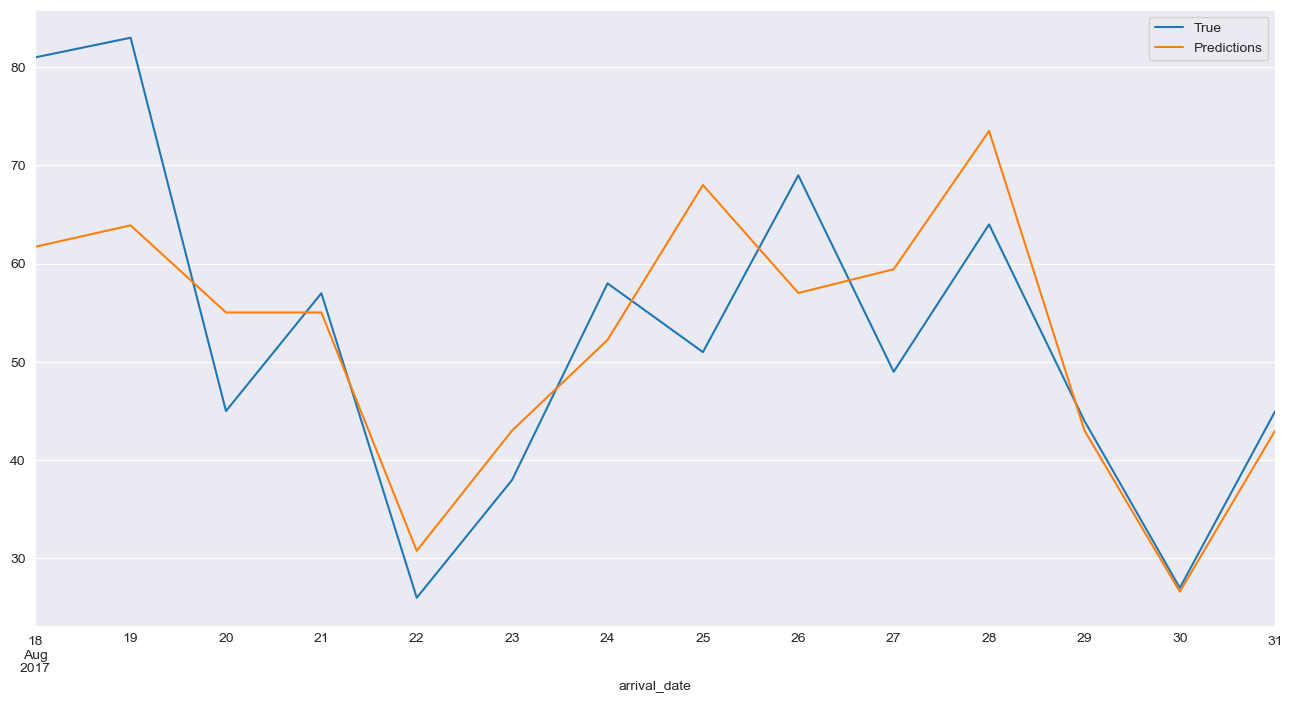

In [603]:
ax = time_data_by_day_2.loc[(time_data_by_day_2.index >= time_test_2.index[0]) &
                            (time_data_by_day_2.index <= time_test_2.index[-1])]['is_canceled'].plot(figsize=(16,8))
time_data_by_day_2.loc[(time_data_by_day_2.index >= time_test_2.index[0]) &
                       (time_data_by_day_2.index <= time_test_2.index[-1])]['prediction_2'].plot(ax = ax)
plt.legend(['True', 'Predictions'])
plt.show()

In [369]:
time_data_by_day.head()

,is_canceled,total_bookings,prediction_x,prediction_y,prediction_x,prediction_y,prediction,prediction_2
arrival_date,,,,,,,,
2015-07-01,19,122,NaN,NaN,NaN,NaN,NaN,NaN
2015-07-02,57,93,NaN,NaN,NaN,NaN,NaN,NaN
2015-07-03,19,56,NaN,NaN,NaN,NaN,NaN,NaN
2015-07-04,43,88,NaN,NaN,NaN,NaN,NaN,NaN
2015-07-05,16,53,NaN,NaN,NaN,NaN,NaN,NaN


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

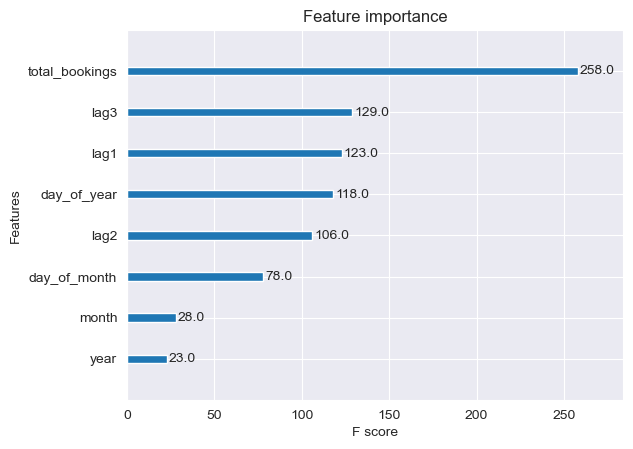

In [604]:
from xgboost import plot_tree, plot_importance
plot_importance(best_model)

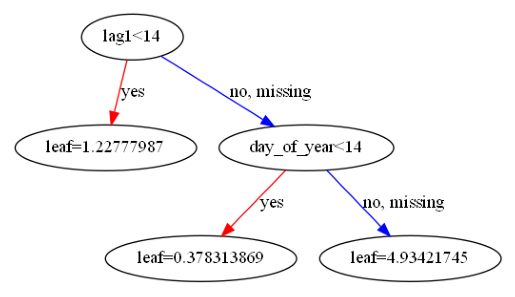

In [605]:
plot_tree(best_model); plt.show()

In [443]:
print(best_model)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.9927286837432157, early_stopping_rounds=100,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             gamma=0.7464693554236559, gpu_id=0, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.14689850783126918, max_bin=428,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=2, max_leaves=None,
             min_child_weight=1.9623507734573744, missing=nan,
             monotone_constraints=None, n_estimators=10000, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=5, ...)
